In [1]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
from scipy.interpolate import interp1d
import scipy as sc
import matplotlib.cm as cm
from salishsea_tools import (nc_tools, gsw_calls, geo_tools, viz_tools)
import seabird
import cmocean as cmo
import gsw

from seabird.cnv import fCNV
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
import scipy.io
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size


from dateutil        import parser
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
%matplotlib inline
sns.set_context('paper')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
plt.style.use('seaborn')


In [245]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/NEP36_2013_T_S_Spice_larger_offshore_rho_correct.nc')


sal = NEP.variables['vosaline']
temp = NEP.variables['votemper']
spic = NEP.variables['spiciness']
rho = NEP.variables['density']

zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]

mask = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/mesh_mask.nc')

tmask = mask.variables['tmask'][0,:32,180:350, 480:650]
umask = mask.variables['umask'][0,:32,180:350, 480:650]
vmask = mask.variables['vmask'][0,:32,180:350, 480:650]
mbathy = mask.variables['mbathy'][0,180:350, 480:650]


y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))




file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

lon = file_model.variables['nav_lon'][1:,1:]
lat = file_model.variables['nav_lat'][1:,1:]



lon_gsw = np.mean(lon)
lat_gsw = np.mean(lat)

bathy_file = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')
Z = bathy_file.variables['Bathymetry'][180:350, 480:650]

In [3]:
path_of_file = '/data/ssahu/Falkor_2013/mvp/'

survey_file_A = path_of_file + 'surveyA.mat'
survey_file_B = path_of_file + 'surveyB.mat'
survey_file_D = path_of_file + 'surveyD.mat'
survey_file_E = path_of_file + 'surveyE.mat'
survey_file_G = path_of_file + 'surveyG.mat'

survey_file = [survey_file_A, survey_file_B, survey_file_D, survey_file_E, survey_file_G]

In [4]:
file = survey_file_E



mat = scipy.io.loadmat(file)

depths_survey = mat['depths'][:,0]
lat_survey = mat['latitude'][:,0]
lon_survey = mat['longitude'][:,0] - 100
# den_survey = mat['density'][:]
pden_survey = mat['pden'][:]
temp_survey = mat['temp'][:]
sal_survey = mat['salinity'][:]
mtime = mat['mtime'][:,0]

In [5]:
y = np.empty_like(temp_survey)

max_depths = np.empty((temp_survey.shape[1]))

y[:,:] = np.isnan(temp_survey)

for i in np.arange(max_depths.shape[0]):
    if (np.isfinite(temp_survey[:,i])).any() == True:
        max_depths[i] = np.max(depths_survey[np.isfinite(temp_survey[:,i])])
        
q = np.empty_like(lon_survey)
p = np.empty_like(q)

In [6]:
for i in np.arange(lat_survey.shape[0]):
    q[i], p[i] = geo_tools.find_closest_model_point(
               lon_survey[i],lat_survey[i],lon,lat,tols={
        'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
    
q = q.astype(int)
p = p.astype(int)

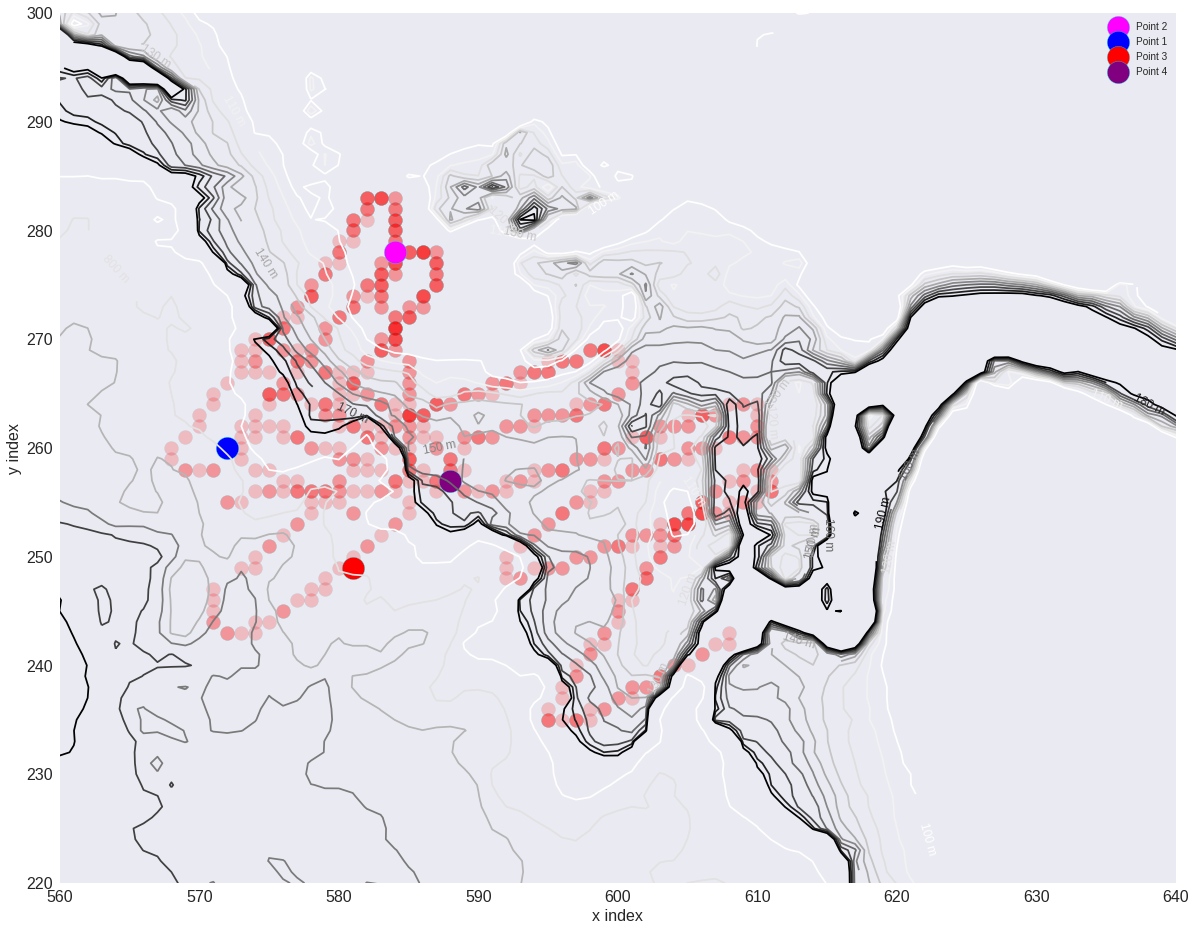

In [16]:
colors = cmo.cm.phase(np.linspace(0, 1, p.shape[0]))
# # plt.style.use('default')

# sns.set_context('paper')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.style.use('seaborn')

cmap = cmo.cm.deep
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], level = [0,500,1000], color = 'k' )
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




for i in np.arange(p.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(p[i])], y_wcvi_slice[np.int(q[i])], c = 'Red', cmap = cmap, s=200, alpha=0.2, edgecolor= 'cyan' )


#First Attempt to select 2 points

ax.scatter(x_wcvi_slice[np.int(p[500])], y_wcvi_slice[np.int(q[500])], c = 'magenta', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 2' )

ax.scatter(x_wcvi_slice[np.int(p[420])], y_wcvi_slice[np.int(q[420])], c = 'blue', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 1' )    

# ax.scatter(x_wcvi_slice[np.int(p[220])], y_wcvi_slice[np.int(q[220])], c = 'purple', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 4' )    

ax.scatter(x_wcvi_slice[np.int(p[688])], y_wcvi_slice[np.int(q[688])], c = 'red', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 3' ) 

ax.scatter(x_wcvi_slice[np.int(p[552])], y_wcvi_slice[np.int(q[552])], c = 'purple', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 4' ) 

ax.set_ylim(220,300)
ax.set_xlim(560,640)
    
ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
ax.legend(loc = 'best')


In [11]:

np.where((y_wcvi_slice[q[:]]>250) & (y_wcvi_slice[q[:]]<260) & (x_wcvi_slice[p[:]]>580) & (x_wcvi_slice[p[:]]<593))

(array([218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 543, 544,
        545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 611,
        612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 650,
        651, 653, 654, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699,
        700, 701]),)

In [233]:
i1 = 420
i2 = 500

pden_point_1 = pden_survey[:,i1]
pden_point_2 = pden_survey[:,i2]

lat_point_1 = lat_survey[i1]
lat_point_2 = lat_survey[i2]

lon_point_1 = lon_survey[i1]
lon_point_2 = lon_survey[i2]

diff_rho = pden_point_2 - pden_point_1

dist = 1000*geo_tools.haversine(lon_point_1, lat_point_1, lon_point_2, lat_point_2)

drho = np.empty_like(diff_rho)

drho[:] = (diff_rho[:]/dist)
       
drho = np.nancumsum(drho)

In [234]:
if file == survey_file_E:
    t = 119
    
if file == survey_file_D:
    t = 118

q = q.astype(int)
p = p.astype(int)
    
pden_model_point_1 = rho[t,:,q[i1],p[i1]]
pden_model_point_2 = rho[t,:,q[i2],p[i2]]

pden_model_point_2[pden_model_point_2<1000] = 'Nan'

lat_model_point_1 = lat[q[i1],p[i1]]
lat_model_point_2 = lat[q[i2],p[i2]]

lon_model_point_1 = lon[q[i1],p[i1]]
lon_model_point_2 = lon[q[i2],p[i2]]

diff_rho_model = pden_model_point_2 - pden_model_point_1

dist_model = 1000*geo_tools.haversine(lon_model_point_1, lat_model_point_1, lon_model_point_2, lat_model_point_2)

zdiff = np.diff(zlevels,axis=0)

drho_model = np.empty_like(zdiff)

drho_model[:] = (diff_rho_model[1:]/dist)*zdiff[:]
       
drho_model = np.cumsum(drho_model)


Between points 1 and 2 (Upstream of Barkley Canyon)


(-0.003, 0.003)

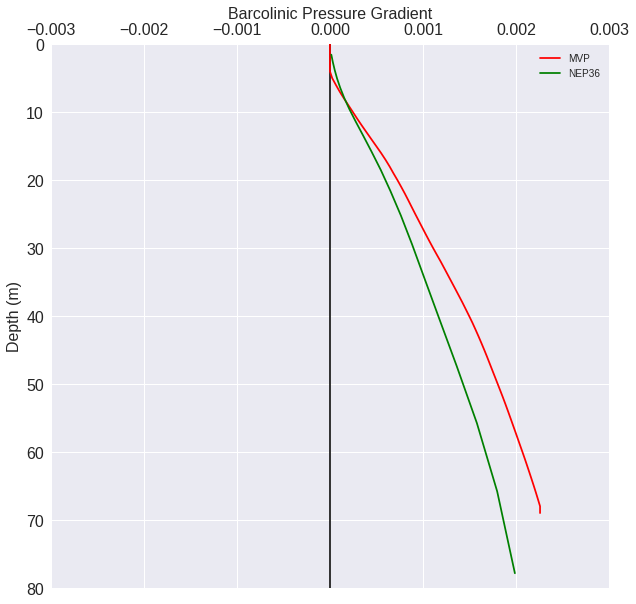

In [235]:
print("Between points 1 and 2 (Upstream of Barkley Canyon)")


fig2, ax2 = plt.subplots(1,1,figsize=(10,10))

zmax_level_mvp = pden_point_2[~np.isnan(pden_point_2)].shape



ax2.plot(drho[:zmax_level_mvp[0]+5] , depths_survey[:zmax_level_mvp[0]+5],  c = 'red',  label = 'MVP')
  
ax2.plot(drho_model[:] , zlevels[1:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,80)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Barcolinic Pressure Gradient', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')
ax2.set_xlim(-0.003,0.003)

In [17]:
i1 = 688
i2 = 552 #220

pden_point_1 = pden_survey[:,i1]
pden_point_2 = pden_survey[:,i2]

lat_point_1 = lat_survey[i1]
lat_point_2 = lat_survey[i2]

lon_point_1 = lon_survey[i1]
lon_point_2 = lon_survey[i2]

diff_rho = pden_point_2 - pden_point_1

dist = 1000*geo_tools.haversine(lon_point_1, lat_point_1, lon_point_2, lat_point_2)

drho = np.empty_like(diff_rho)

drho[:] = (diff_rho[:]/dist)
       
drho = np.nancumsum(drho)

In [18]:
if file == survey_file_E:
    t = 119
    
if file == survey_file_D:
    t = 118

q = q.astype(int)
p = p.astype(int)
    
pden_model_point_1 = rho[t,:,q[i1],p[i1]]
pden_model_point_2 = rho[t,:,q[i2],p[i2]]

pden_model_point_2[pden_model_point_2<1000] = 'Nan'

lat_model_point_1 = lat[q[i1],p[i1]]
lat_model_point_2 = lat[q[i2],p[i2]]

lon_model_point_1 = lon[q[i1],p[i1]]
lon_model_point_2 = lon[q[i2],p[i2]]

diff_rho_model = pden_model_point_2 - pden_model_point_1

dist_model = 1000*geo_tools.haversine(lon_model_point_1, lat_model_point_1, lon_model_point_2, lat_model_point_2)

zdiff = np.diff(zlevels,axis=0)

drho_model = np.empty_like(zdiff)

drho_model[:] = (diff_rho_model[1:]/dist)*zdiff[:]
       
drho_model = np.cumsum(drho_model)


Between points 3 and 4 (Downstream of Barkley Canyon)


(-0.0035, 0.0035)

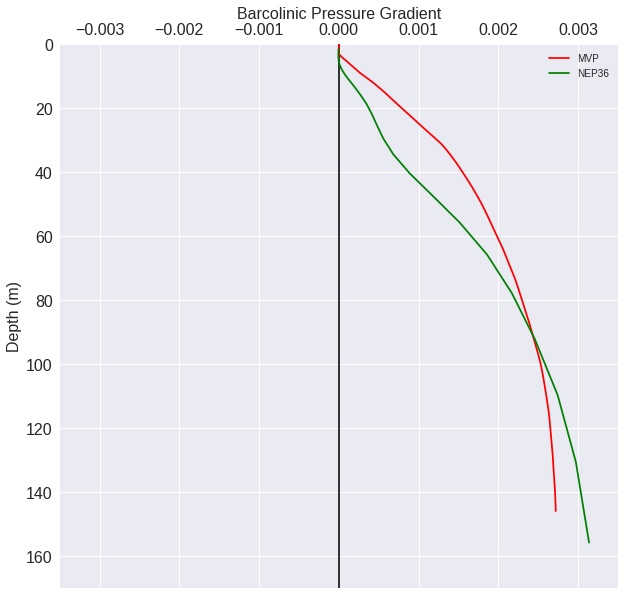

In [19]:
print("Between points 3 and 4 (Downstream of Barkley Canyon)")


fig2, ax2 = plt.subplots(1,1,figsize=(10,10))

zmax_level_mvp = pden_point_2[~np.isnan(pden_point_2)].shape



ax2.plot(drho[:zmax_level_mvp[0]+5] , depths_survey[:zmax_level_mvp[0]+5],  c = 'red',  label = 'MVP')
  
ax2.plot(drho_model[:] , zlevels[1:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,170)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Barcolinic Pressure Gradient', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')
ax2.set_xlim(-0.0035,0.0035)

### Slightly mistaken cross shore direction yielded the plot below

Between points 3 and 4 (Downstream of Barkley Canyon)


(-0.0035, 0.0035)

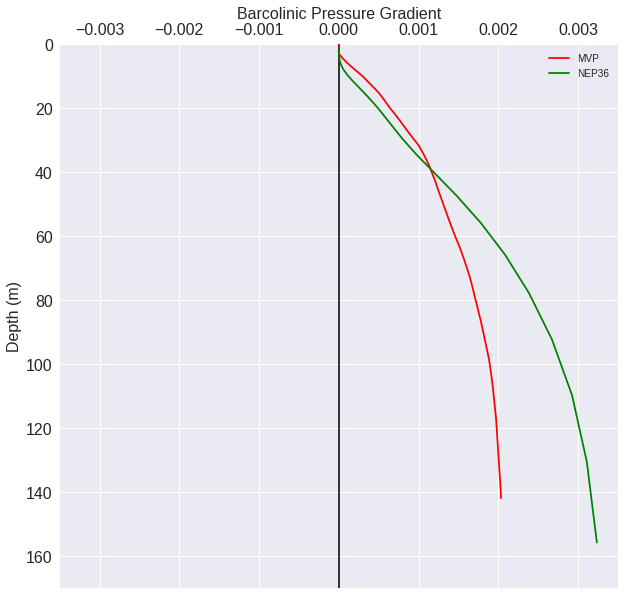

In [238]:
print("Between points 3 and 4 (Downstream of Barkley Canyon)")


fig2, ax2 = plt.subplots(1,1,figsize=(10,10))

zmax_level_mvp = pden_point_2[~np.isnan(pden_point_2)].shape



ax2.plot(drho[:zmax_level_mvp[0]+5] , depths_survey[:zmax_level_mvp[0]+5],  c = 'red',  label = 'MVP')
  
ax2.plot(drho_model[:] , zlevels[1:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,170)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Barcolinic Pressure Gradient', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')
ax2.set_xlim(-0.0035,0.0035)

In [17]:
file = survey_file_D



mat = scipy.io.loadmat(file)

depths_survey = mat['depths'][:,0]
lat_survey = mat['latitude'][:,0]
lon_survey = mat['longitude'][:,0] - 100
# den_survey = mat['density'][:]
pden_survey = mat['pden'][:]
temp_survey = mat['temp'][:]
sal_survey = mat['salinity'][:]
mtime = mat['mtime'][:,0]

In [18]:
y = np.empty_like(temp_survey)

max_depths = np.empty((temp_survey.shape[1]))

y[:,:] = np.isnan(temp_survey)

for i in np.arange(max_depths.shape[0]):
    if (np.isfinite(temp_survey[:,i])).any() == True:
        max_depths[i] = np.max(depths_survey[np.isfinite(temp_survey[:,i])])
        
q = np.empty_like(lon_survey)
p = np.empty_like(q)

In [19]:
for i in np.arange(lat_survey.shape[0]):
    q[i], p[i] = geo_tools.find_closest_model_point(
               lon_survey[i],lat_survey[i],lon,lat,tols={
        'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
    
q = q.astype(int)
p = p.astype(int)

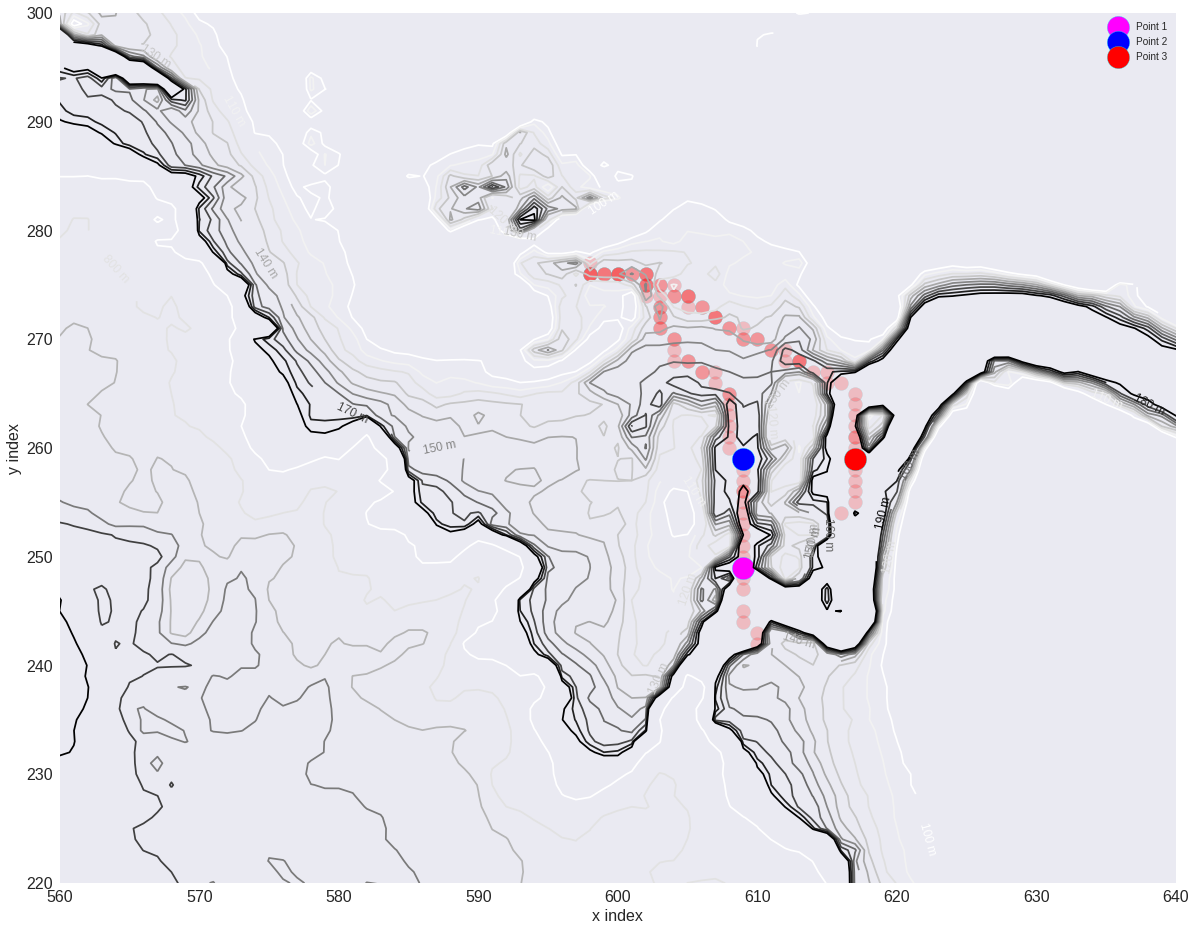

In [56]:
colors = cmo.cm.phase(np.linspace(0, 1, p.shape[0]))
# # plt.style.use('default')

# sns.set_context('paper')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.style.use('seaborn')

cmap = cmo.cm.deep
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], level = [0,500,1000], color = 'k' )
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




for i in np.arange(p.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(p[i])], y_wcvi_slice[np.int(q[i])], c = 'Red', cmap = cmap, s=200, alpha=0.2, edgecolor= 'cyan' )


#First Attempt to select 2 points

ax.scatter(x_wcvi_slice[np.int(p[101])], y_wcvi_slice[np.int(q[101])], c = 'magenta', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 1' )

ax.scatter(x_wcvi_slice[np.int(p[90])], y_wcvi_slice[np.int(q[90])], c = 'blue', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 2' )    

ax.scatter(x_wcvi_slice[np.int(p[5])], y_wcvi_slice[np.int(q[5])], c = 'red', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 3' )    

# ax.scatter(x_wcvi_slice[np.int(p[688])], y_wcvi_slice[np.int(q[688])], c = 'red', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 3' ) 

ax.set_ylim(220,300)
ax.set_xlim(560,640)
    
ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
ax.legend(loc = 'best')


In [23]:

np.where((y_wcvi_slice[q[:]]>250) & (y_wcvi_slice[q[:]]<260) & (x_wcvi_slice[p[:]]>610) & (x_wcvi_slice[p[:]]<620))

(array([0, 1, 2, 3, 4, 5]),)

In [20]:
i1 = 101
i2 = 90

pden_point_1 = pden_survey[:,i1]
pden_point_2 = pden_survey[:,i2]

lat_point_1 = lat_survey[i1]
lat_point_2 = lat_survey[i2]

lon_point_1 = lon_survey[i1]
lon_point_2 = lon_survey[i2]

diff_rho = pden_point_2 - pden_point_1

dist = 1000*geo_tools.haversine(lon_point_1, lat_point_1, lon_point_2, lat_point_2)

drho = np.empty_like(diff_rho)

drho[:] = (diff_rho[:]/dist)
       
drho = np.nancumsum(drho)

In [32]:
if file == survey_file_E:
    t = 119
    
if file == survey_file_D:
    t = 118

q = q.astype(int)
p = p.astype(int)
    
pden_model_point_1 = rho[t,:,q[i1],p[i1]]
pden_model_point_2 = rho[t,:,q[i2],p[i2]]

pden_model_point_2[pden_model_point_2<1000] = 'Nan'

lat_model_point_1 = lat[q[i1],p[i1]]
lat_model_point_2 = lat[q[i2],p[i2]]

lon_model_point_1 = lon[q[i1],p[i1]]
lon_model_point_2 = lon[q[i2],p[i2]]

diff_rho_model = pden_model_point_2 - pden_model_point_1

dist_model = 1000*geo_tools.haversine(lon_model_point_1, lat_model_point_1, lon_model_point_2, lat_model_point_2)

zdiff = np.diff(zlevels,axis=0)

drho_model = np.empty_like(zdiff)

drho_model[:] = (diff_rho_model[1:]/dist)*zdiff[:]
       
drho_model = np.cumsum(drho_model)


### Between points 1 and 2

Between points 1 and 2 (Through the Tully Canyon)


(-0.0035, 0.0035)

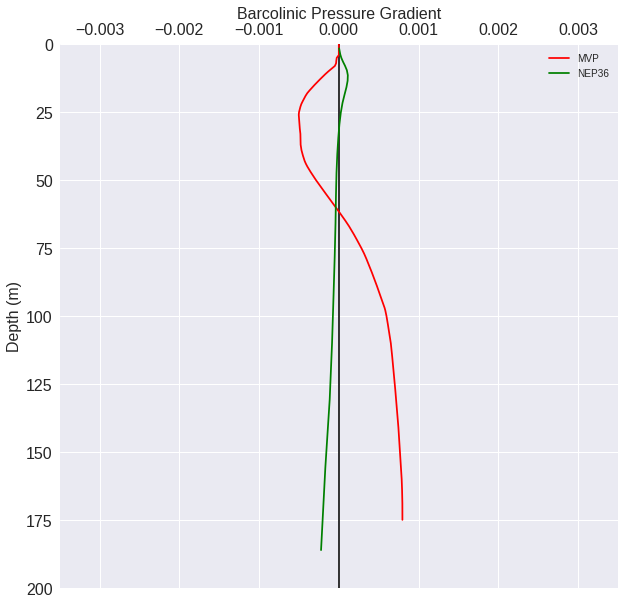

In [33]:
print("Between points 1 and 2 (Through the Tully Canyon)")

fig2, ax2 = plt.subplots(1,1,figsize=(10,10))

zmax_level_mvp = pden_point_2[~np.isnan(pden_point_2)].shape



ax2.plot(drho[:zmax_level_mvp[0]+5] , depths_survey[:zmax_level_mvp[0]+5],  c = 'red',  label = 'MVP')
  
ax2.plot(drho_model[:] , zlevels[1:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,200)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Barcolinic Pressure Gradient', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')
ax2.set_xlim(-0.0035,0.0035)

In [21]:
i1 = 90
i2 = 5

pden_point_1 = pden_survey[:,i1]
pden_point_2 = pden_survey[:,i2]

lat_point_1 = lat_survey[i1]
lat_point_2 = lat_survey[i2]

lon_point_1 = lon_survey[i1]
lon_point_2 = lon_survey[i2]

diff_rho = pden_point_2 - pden_point_1

dist = 1000*geo_tools.haversine(lon_point_1, lat_point_1, lon_point_2, lat_point_2)

drho = np.empty_like(diff_rho)

drho[:] = (diff_rho[:]/dist)
       
drho = np.nancumsum(drho)

In [28]:
if file == survey_file_E:
    t = 119
    
if file == survey_file_D:
    t = 118

q = q.astype(int)
p = p.astype(int)
    
pden_model_point_1 = rho[t,:,q[i1],p[i1]]
pden_model_point_2 = rho[t,:,q[i2],p[i2]]

pden_model_point_2[pden_model_point_2<1000] = 'Nan'

lat_model_point_1 = lat[q[i1],p[i1]]
lat_model_point_2 = lat[q[i2],p[i2]]

lon_model_point_1 = lon[q[i1],p[i1]]
lon_model_point_2 = lon[q[i2],p[i2]]

diff_rho_model = pden_model_point_2 - pden_model_point_1

dist_model = 1000*geo_tools.haversine(lon_model_point_1, lat_model_point_1, lon_model_point_2, lat_model_point_2)

zdiff = np.diff(zlevels,axis=0)

drho_model = np.empty_like(zdiff)

drho_model[:] = (diff_rho_model[1:]/dist)*zdiff[:]
       
drho_model = np.cumsum(drho_model)


Between points 2 and 3 (Through the Tully Canyon)


(-0.0035, 0.0035)

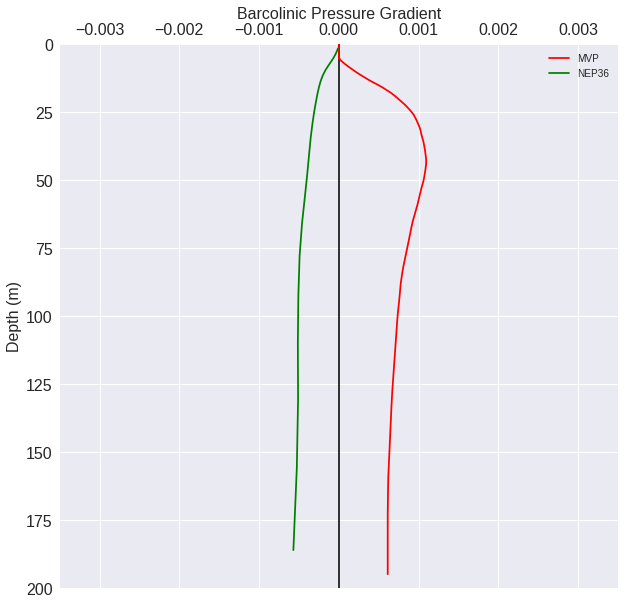

In [30]:
print("Between points 2 and 3 (Through the Tully Canyon)")

fig2, ax2 = plt.subplots(1,1,figsize=(10,10))

zmax_level_mvp = pden_point_2[~np.isnan(pden_point_2)].shape



ax2.plot(drho[:zmax_level_mvp[0]+5] , depths_survey[:zmax_level_mvp[0]+5],  c = 'red',  label = 'MVP')
  
ax2.plot(drho_model[:] , zlevels[1:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,200)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Barcolinic Pressure Gradient', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')
ax2.set_xlim(-0.0035,0.0035)

### Observation: Almost uniform with depth ??

In [3]:
u_vel_file = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_U_20130817-20130826.nc')
v_vel_file = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_V_20130817-20130826.nc')

u_vel_slice_date = u_vel_file.variables['uo'][7,:,1:,1:]
v_vel_slice_date = v_vel_file.variables['vo'][7,:,1:,1:]

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


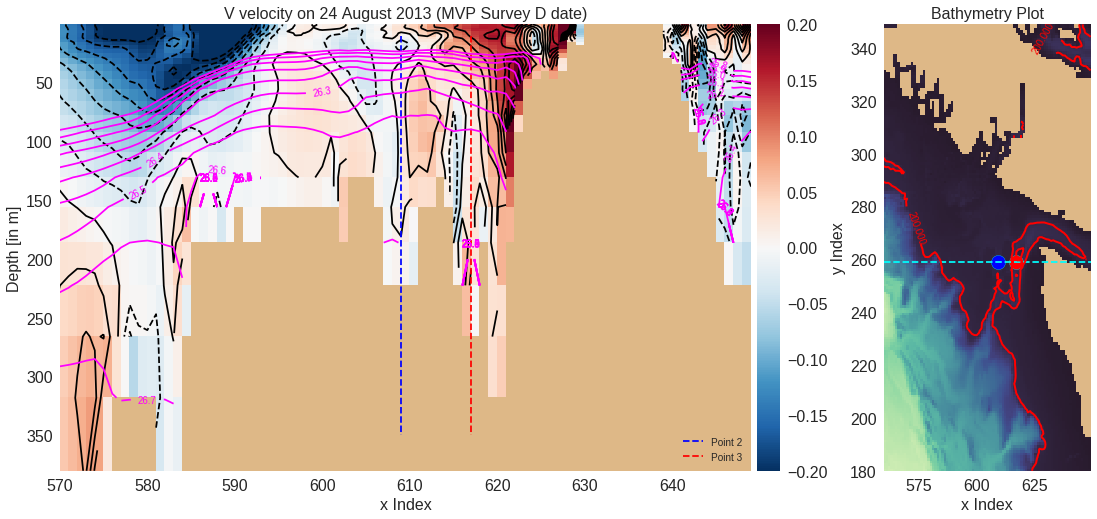

In [116]:
t = 118


import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)



# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))

land_colour = 'burlywood'

axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[...], cmap=cmap, vmin=0)

# axr.scatter(x_wcvi_slice[np.int(p[i1])], y_wcvi_slice[np.int(q[i1])], c = 'cyan', cmap = cmap, s=200, alpha=1, edgecolor= 'cyan', label = 'NEP36 Point' )    

legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot', fontsize = 16)
axr.set_xlabel('x Index', fontsize = 16)
axr.set_ylabel('y Index', fontsize = 16)
axr.set_xlim(560)
axr.hlines(y_wcvi_slice[np.int(q[i1])], xmin = 560, xmax = 650, linestyles= 'dashed', colors='cyan')
axr.scatter(x_wcvi_slice[np.int(p[90])], y_wcvi_slice[np.int(q[90])], c = 'blue', cmap = cmap, s=200, alpha=1, edgecolor= 'cyan', label = 'Point 2' )    

axr.scatter(x_wcvi_slice[np.int(p[5])], y_wcvi_slice[np.int(q[5])], c = 'red', cmap = cmap, s=200, alpha=1, edgecolor= 'cyan', label = 'Point 3' )    

CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[...], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()





v_0 = v_vel_slice_date[:,:,:]
v_masked = np.ma.array(v_0, mask =1- vmask)



cmap = plt.cm.get_cmap('RdBu_r')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,q[i1],:], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
# cbar.set_label('V Velocity', fontsize = 16)
clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,q[i1],:], np.arange(-0.2, 0.2, 0.03), colors='black')
# axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlim(570)
axl.set_xlabel('x Index', fontsize = 16)
axl.set_ylabel('Depth [in m]', fontsize = 16)
axl.set_sketch_params('paper')
axl.vlines(x_wcvi_slice[p[i1]], ymin = 10, ymax = 350, linestyles= 'dashed', colors='blue', label = 'Point 2')
axl.vlines(x_wcvi_slice[p[i2]], ymin = 10, ymax = 350, linestyles= 'dashed', colors='red', label = 'Point 3')
axl.set_title('V velocity on 24 August 2013 (MVP Survey D date)', fontsize = 16)
axl.legend(loc = 'lower right')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.tick_params(axis='both',labelsize =16)

axcb.tick_params(axis='both',labelsize =16)

axr.tick_params(axis='both',labelsize =16)
# axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')

rho_0 = rho[t,:,:,:]
rho_tzyx = np.ma.array(rho_0, mask = 1 - tmask)    
clines = axl.contour(x_wcvi_slice, zlevels[:30], rho_tzyx[:30,q[i1],:] - 1000,np.arange(25.8, 26.8, 0.1), colors='magenta')
axl.clabel(clines, fmt='%1.1f', inline=True)

plt.show()

In [4]:
A1_data = pd.read_table('/data/ssahu/IOS_data/ADCP_E1_A1/a1_20130707_20140524_0498m.csv',delim_whitespace=1,header = None, skiprows=426)

str_stuff = np.array(['Record_Number', 'Date', 'Time', 'Pitch', 'Roll', 'Heading', 'Pressure', 'Temperature'], dtype = 'str')

bin_depths = np.array([84.44, 100.44, 116.44, 132.44, 148.44, 164.44, 180.44, 196.44, 212.44, 228.44, 244.44, 260.44, 276.44\
              , 292.44, 308.44, 324.44, 340.44, 356.44, 372.44, 388.44, 404.44, 420.44, 436.44, 452.44, 468.44], dtype = 'str')

variables = np.array(['vel_north', 'vel_east', 'vel_vert', 'back_scatter_mean'], dtype = 'str')

column_data = []

for j in bin_depths:
    for i in variables:
        column_data = np.append(arr=column_data, values=i+'_'+j)
    

columns_A1 = np.concatenate((str_stuff, column_data), axis = 0)

A1_data.columns = columns_A1

In [5]:
vel_north_84 = np.array(A1_data['vel_north_84.44'], dtype = np.float)[:5284]
vel_east_84  = np.array(A1_data['vel_east_84.44'], dtype = np.float)[:5284]
mag_84       = np.sqrt(vel_east_84**2+vel_north_84**2)
mag_84[mag_84 > 2] = 'Nan'

vel_north_100= np.array(A1_data['vel_north_100.44'], dtype = np.float)[:5284]
vel_east_100 = np.array(A1_data['vel_east_100.44'], dtype = np.float)[:5284]
mag_100       = np.sqrt(vel_east_100**2+vel_north_100**2)
mag_100[mag_100 > 2] = 'Nan'

vel_north_116 = np.array(A1_data['vel_north_116.44'], dtype = np.float)[:5284]
vel_east_116  = np.array(A1_data['vel_east_116.44'], dtype = np.float)[:5284]
mag_116       = np.sqrt(vel_east_116**2+vel_north_116**2)
mag_116[mag_116 > 2] = 'Nan'

vel_north_148 = np.array(A1_data['vel_north_148.44'], dtype = np.float)[:5284]
vel_east_148  = np.array(A1_data['vel_east_148.44'], dtype = np.float)[:5284]
mag_148       = np.sqrt(vel_east_148**2+vel_north_148**2)

vel_north_164= np.array(A1_data['vel_north_164.44'], dtype = np.float)[:5284]
vel_east_164 = np.array(A1_data['vel_east_164.44'], dtype = np.float)[:5284]
mag_164       = np.sqrt(vel_east_164**2+vel_north_164**2)
mag_164[mag_164 > 2] = 'Nan'

vel_north_180= np.array(A1_data['vel_north_180.44'], dtype = np.float)[:5284]
vel_east_180 = np.array(A1_data['vel_east_180.44'], dtype = np.float)[:5284]
mag_180       = np.sqrt(vel_east_180**2+vel_north_180**2)
mag_180[mag_180 > 2] = 'Nan'

vel_north_196 = np.array(A1_data['vel_north_196.44'], dtype = np.float)[:5284]
vel_east_196  = np.array(A1_data['vel_east_196.44'], dtype = np.float)[:5284]
mag_196      = np.sqrt(vel_east_196**2+vel_north_196**2)

vel_north_228 = np.array(A1_data['vel_north_228.44'], dtype = np.float)[:5284]
vel_east_228 = np.array(A1_data['vel_east_228.44'], dtype = np.float)[:5284]
mag_228      = np.sqrt(vel_east_228**2+vel_north_228**2)

vel_north_260 = np.array(A1_data['vel_north_260.44'], dtype = np.float)[:5284]
vel_east_260 = np.array(A1_data['vel_east_260.44'], dtype = np.float)[:5284]
mag_260      = np.sqrt(vel_east_260**2+vel_north_260**2)

vel_north_276 = np.array(A1_data['vel_north_276.44'], dtype = np.float)[:5284]
vel_east_276 = np.array(A1_data['vel_east_276.44'], dtype = np.float)[:5284]
mag_276      = np.sqrt(vel_east_276**2+vel_north_276**2)

vel_north_292 = np.array(A1_data['vel_north_292.44'], dtype = np.float)[:5284]
vel_east_292 = np.array(A1_data['vel_east_292.44'], dtype = np.float)[:5284]
mag_292      = np.sqrt(vel_east_292**2+vel_north_292**2)

vel_north_308 = np.array(A1_data['vel_north_308.44'], dtype = np.float)[:5284]
vel_east_308 = np.array(A1_data['vel_east_308.44'], dtype = np.float)[:5284]
mag_308      = np.sqrt(vel_east_308**2+vel_north_308**2)

vel_north_340 = np.array(A1_data['vel_north_340.44'], dtype = np.float)[:5284]
vel_east_340 = np.array(A1_data['vel_east_340.44'], dtype = np.float)[:5284]
mag_340      = np.sqrt(vel_east_340**2+vel_north_340**2)

vel_north_372 = np.array(A1_data['vel_north_372.44'], dtype = np.float)[:5284]
vel_east_372 = np.array(A1_data['vel_east_372.44'], dtype = np.float)[:5284]
mag_372      = np.sqrt(vel_east_372**2+vel_north_372**2)

vel_north_388 = np.array(A1_data['vel_north_388.44'], dtype = np.float)[:5284]
vel_east_388 = np.array(A1_data['vel_east_388.44'], dtype = np.float)[:5284]
mag_388      = np.sqrt(vel_east_388**2+vel_north_388**2)

In [39]:
np.where(mag_84 == np.max(mag_84))

(array([   6,   28,   29,   30,   31,   89,   90,   94,   95,   96,   97,
          98,   99,  177,  229, 2382, 2383, 2384, 2386, 2387]),)

In [41]:
vel_east_84[28]

-99.0

In [6]:
tarikh = np.array(A1_data['Date'], dtype = np.str)
samai  = np.array(A1_data['Time'], dtype = np.str)

time = np.empty_like(tarikh)

for i in np.arange(tarikh.shape[0]):
    time[i] = tarikh[i] + '' + samai[i]


datetime_A1 = np.empty_like(time)

for i in np.arange(datetime_A1.shape[0]):
    datetime_A1[i] = datetime.strptime(time[i], '%Y/%m/%d%H:%M:%S')
    
datetime_A1 = datetime_A1.astype(np.datetime64)


In [7]:
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=0,vmax=0.2)


cm = plt.get_cmap(cmo.cm.matter)
# cmap.set_bad('Burlywood')

# norm = matplotlib.colors.Normalize()
# norm.autoscale(~np.isnan(mag_84))
# cm = matplotlib.cm.copper

sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])

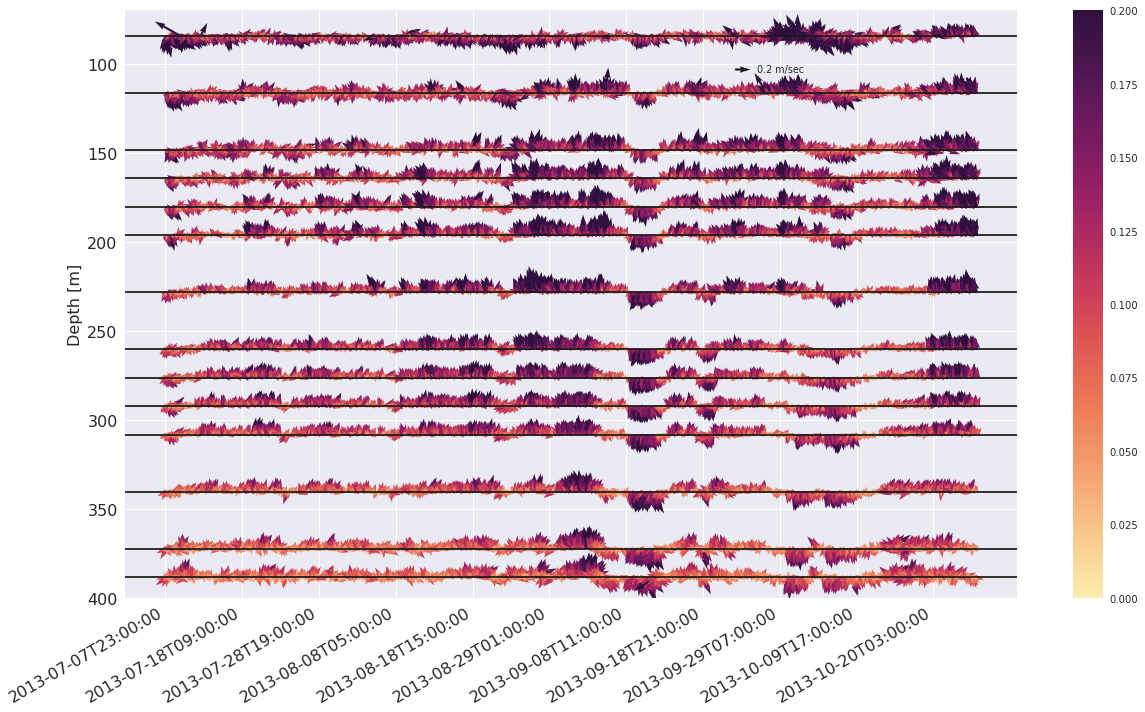

In [84]:
# sns.set()
sns.set_style('dark')
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

step = 1

# u_84 = vel_east_84[:4320]
# v_84 = vel_north_84[:4320]
# mag_84 = np.sqrt(u_84**2,v_84**2)





time_axis = datetime_A1[:5284]
time_tick = time_axis[::step]
time_axis_quiver = np.arange(0,5284,step)



fig, ax = plt.subplots(1, 1, figsize=(20,12))


ax.quiver(time_axis_quiver, 84.44, vel_east_84[::step], vel_north_84[::step], mag_84[::step], angles='uv', cmap = cm, norm = norm, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=84.44, color='k', label = '84 m')

# ax.quiver(time_axis_quiver, 100.44, vel_east_100[::step], vel_north_100[::step], mag_100[::step], angles='uv', cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
# ax.axhline(y=100.44, color='k', label = '100 m')

ax.quiver(time_axis_quiver, 116.44, vel_east_116[::step], vel_north_116[::step], mag_116[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=116.44, color='k', label = '116 m')

ax.quiver(time_axis_quiver, 148.44, vel_east_148[::step], vel_north_148[::step], mag_148[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=148.44, color='k', label = '148 m')

ax.quiver(time_axis_quiver, 164.44, vel_east_164[::step], vel_north_164[::step], mag_164[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=164.44, color='k', label = '164 m')

ax.quiver(time_axis_quiver, 180.44, vel_east_180[::step], vel_north_180[::step], mag_180[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=180.44, color='k', label = '180 m')

ax.quiver(time_axis_quiver, 196.44, vel_east_196[::step], vel_north_196[::step], mag_196[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=196.44, color='k', label = '196 m')

Q = ax.quiver(time_axis_quiver, 228.44, vel_east_228[::step], vel_north_228[::step], mag_228[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=228.44, color='k', label = '228 m')

ax.quiver(time_axis_quiver, 260.44, vel_east_260[::step], vel_north_260[::step], mag_260[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=260.44, color='k', label = '260 m')

ax.quiver(time_axis_quiver, 276.44, vel_east_276[::step], vel_north_276[::step], mag_276[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=276.44, color='k', label = '276 m')

ax.quiver(time_axis_quiver, 292.44, vel_east_292[::step], vel_north_292[::step], mag_292[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=292.44, color='k', label = '292 m')

ax.quiver(time_axis_quiver, 308.44, vel_east_308[::step], vel_north_308[::step], mag_308[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=308.44, color='k', label = '308 m')

ax.quiver(time_axis_quiver, 340.44, vel_east_340[::step], vel_north_340[::step], mag_340[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=340.44, color='k', label = '340 m')

ax.quiver(time_axis_quiver, 372.44, vel_east_372[::step], vel_north_372[::step], mag_372[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=372.44, color='k', label = '372 m')

ax.quiver(time_axis_quiver, 388.44, vel_east_388[::step], vel_north_388[::step], mag_388[::step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=388.44, color='k', label = '388 m')


ax.set_ylabel('Depth [m]', fontsize =16)
plt.xticks(time_axis_quiver[::500], time_tick[::500], fontsize = 16)
# ax.format_xdata = DateFormatter('%Y-%m-%d')
fig.autofmt_xdate()
ax.set_ylim(70, 400)
ax.invert_yaxis()
ax.tick_params(axis='both',labelsize =16)

ax.quiverkey(Q, 0.7, 0.9, 0.2, r'0.2 m/sec', labelpos='E', coordinates='axes')
# legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.grid() 
plt.colorbar(sm)


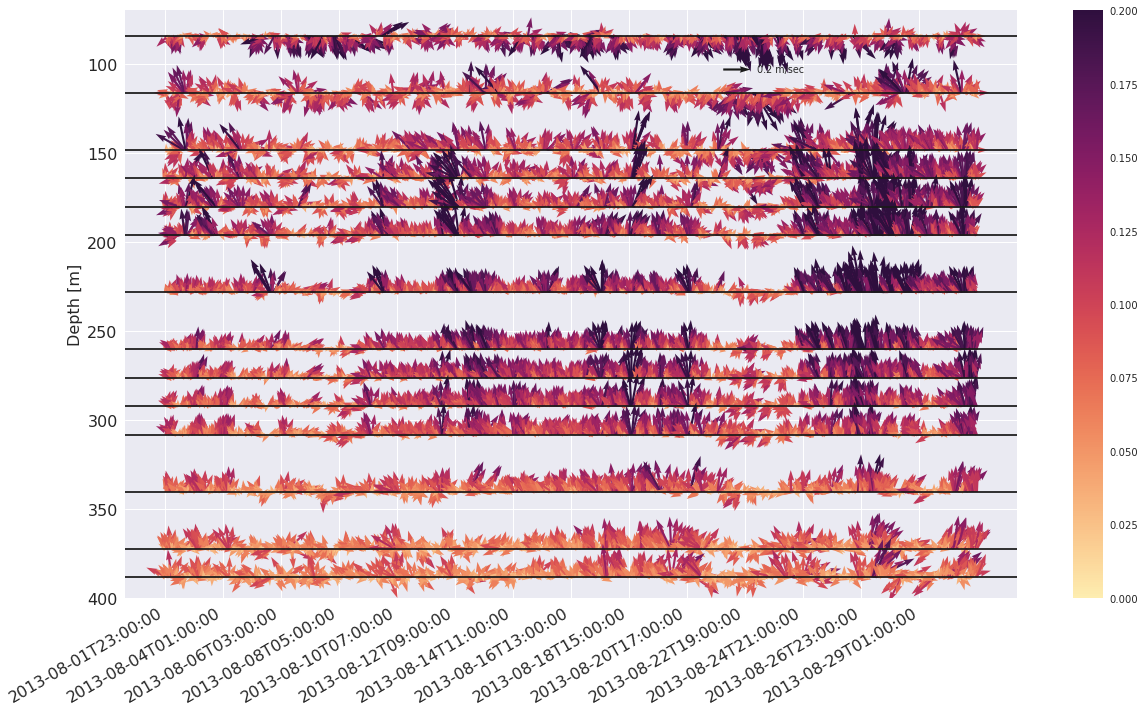

In [44]:
# sns.set()
sns.set_style('dark')
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

step = 1

# u_84 = vel_east_84[:4320]
# v_84 = vel_north_84[:4320]
# mag_84 = np.sqrt(u_84**2,v_84**2)





time_axis = datetime_A1[:5284]
time_tick = time_axis[::step]
time_axis_quiver = np.arange(0,5284,step)

time_tick = time_tick[1200:2600]
time_axis_quiver = np.arange(1200,2600,step)





fig, ax = plt.subplots(1, 1, figsize=(20,12))


ax.quiver(time_axis_quiver, 84.44, vel_east_84[1200:2600:step], vel_north_84[1200:2600:step], mag_84[1200:2600:step], angles='uv', cmap = cm, norm = norm, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=84.44, color='k', label = '84 m')

# ax.quiver(time_axis_quiver, 100.44, vel_east_100[::step], vel_north_100[::step], mag_100[::step], angles='uv', cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
# ax.axhline(y=100.44, color='k', label = '100 m')

ax.quiver(time_axis_quiver, 116.44, vel_east_116[1200:2600:step], vel_north_116[1200:2600:step], mag_116[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=116.44, color='k', label = '116 m')

ax.quiver(time_axis_quiver, 148.44, vel_east_148[1200:2600:step], vel_north_148[1200:2600:step], mag_148[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=148.44, color='k', label = '148 m')

ax.quiver(time_axis_quiver, 164.44, vel_east_164[1200:2600:step], vel_north_164[1200:2600:step], mag_164[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=164.44, color='k', label = '164 m')

ax.quiver(time_axis_quiver, 180.44, vel_east_180[1200:2600:step], vel_north_180[1200:2600:step], mag_180[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=180.44, color='k', label = '180 m')

ax.quiver(time_axis_quiver, 196.44, vel_east_196[1200:2600:step], vel_north_196[1200:2600:step], mag_196[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=196.44, color='k', label = '196 m')

Q = ax.quiver(time_axis_quiver, 228.44, vel_east_228[1200:2600:step], vel_north_228[1200:2600:step], mag_228[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=228.44, color='k', label = '228 m')

ax.quiver(time_axis_quiver, 260.44, vel_east_260[1200:2600:step], vel_north_260[1200:2600:step], mag_260[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=260.44, color='k', label = '260 m')

ax.quiver(time_axis_quiver, 276.44, vel_east_276[1200:2600:step], vel_north_276[1200:2600:step], mag_276[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=276.44, color='k', label = '276 m')

ax.quiver(time_axis_quiver, 292.44, vel_east_292[1200:2600:step], vel_north_292[1200:2600:step], mag_292[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=292.44, color='k', label = '292 m')

ax.quiver(time_axis_quiver, 308.44, vel_east_308[1200:2600:step], vel_north_308[1200:2600:step], mag_308[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=308.44, color='k', label = '308 m')

ax.quiver(time_axis_quiver, 340.44, vel_east_340[1200:2600:step], vel_north_340[1200:2600:step], mag_340[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=340.44, color='k', label = '340 m')

ax.quiver(time_axis_quiver, 372.44, vel_east_372[1200:2600:step], vel_north_372[1200:2600:step], mag_372[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=372.44, color='k', label = '372 m')

ax.quiver(time_axis_quiver, 388.44, vel_east_388[1200:2600:step], vel_north_388[1200:2600:step], mag_388[1200:2600:step], angles='uv',cmap = cm, norm = norm)#, scale_units='inches')#, scale=0.5)# , minshaft = 3)
ax.axhline(y=388.44, color='k', label = '388 m')


ax.set_ylabel('Depth [m]', fontsize =16)
plt.xticks(time_axis_quiver[::100], time_tick[::100], fontsize = 16)
# ax.format_xdata = DateFormatter('%Y-%m-%d')
fig.autofmt_xdate()
ax.set_ylim(70, 400)
ax.invert_yaxis()
ax.tick_params(axis='both',labelsize =16)

ax.quiverkey(Q, 0.7, 0.9, 0.2, r'0.2 m/sec', labelpos='E', coordinates='axes')
# legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.grid() 
plt.colorbar(sm)


In [9]:
mydates = np.array(pd.date_range(datetime_A1[:5284][0], datetime_A1[:5284][-1], freq="30min"))

In [10]:
A1_series_east = pd.Series(vel_east_84, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_84_daily_east = daily_east.values
east_84 = np.divide(vel_84_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_84, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_84_daily_north = daily_north.values
north_84 = np.divide(vel_84_daily_north[:], 24)


Speed_84 = np.sqrt(east_84**2 + north_84**2)


A1_series_east = pd.Series(vel_east_148, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_148_daily_east = daily_east.values
east_148 = np.divide(vel_148_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_148, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_148_daily_north = daily_north.values
north_148 = np.divide(vel_148_daily_north[:], 24)


Speed_148 = np.sqrt(east_148**2 + north_148**2)


A1_series_east = pd.Series(vel_east_196, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_196_daily_east = daily_east.values
east_196 = np.divide(vel_196_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_196, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_196_daily_north = daily_north.values
north_196 = np.divide(vel_196_daily_north[:], 24)


Speed_196 = np.sqrt(east_196**2 + north_196**2)


A1_series_east = pd.Series(vel_east_228, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_228_daily_east = daily_east.values
east_228 = np.divide(vel_228_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_228, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_228_daily_north = daily_north.values
north_228 = np.divide(vel_228_daily_north[:], 24)


Speed_228 = np.sqrt(east_228**2 + north_228**2)


A1_series_east = pd.Series(vel_east_260, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_260_daily_east = daily_east.values
east_260 = np.divide(vel_260_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_260, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_260_daily_north = daily_north.values
north_260 = np.divide(vel_260_daily_north[:], 24)


Speed_260 = np.sqrt(east_260**2 + north_260**2)


A1_series_east = pd.Series(vel_east_340, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_340_daily_east = daily_east.values
east_340 = np.divide(vel_340_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_340, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_340_daily_north = daily_north.values
north_340 = np.divide(vel_340_daily_north[:], 24)


Speed_340 = np.sqrt(east_340**2 + north_340**2)


A1_series_east = pd.Series(vel_east_388, index=mydates)
daily_east = A1_series_east.resample('1440T').sum()
vel_388_daily_east = daily_east.values
east_388 = np.divide(vel_388_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_388, index=mydates)
daily_north = A1_series_north.resample('1440T').sum()
vel_388_daily_north = daily_north.values
north_388 = np.divide(vel_388_daily_north[:], 24)


Speed_388 = np.sqrt(east_388**2 + north_388**2)

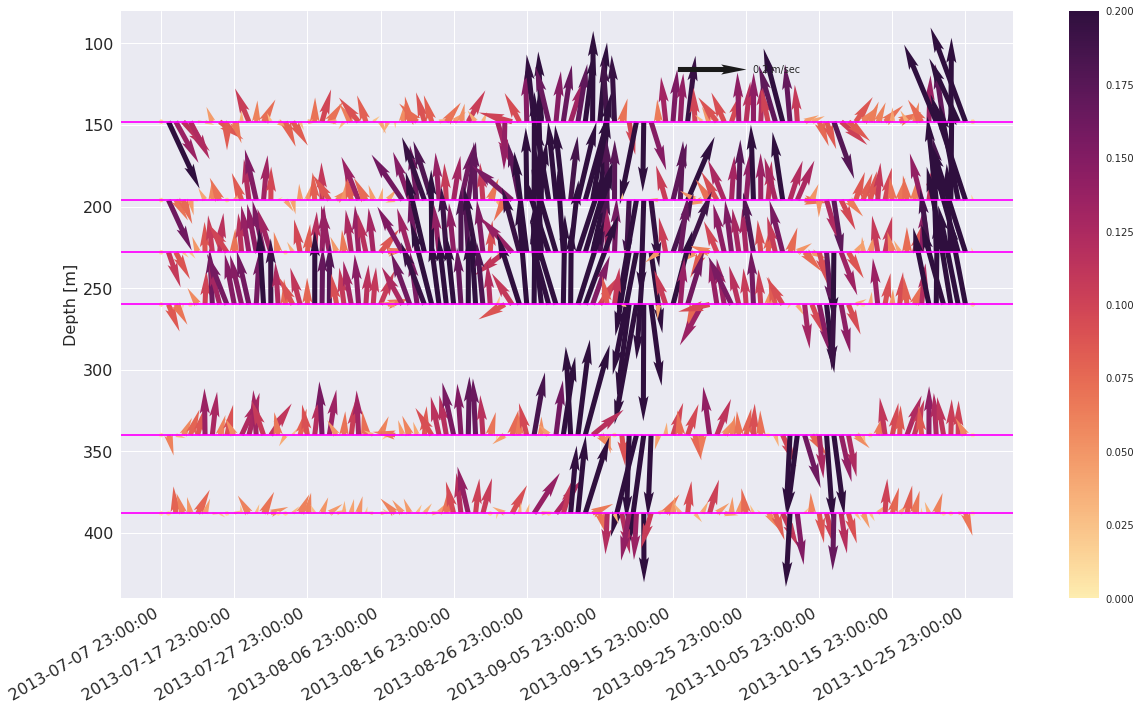

In [13]:
sns.set_style('dark')

step = 1

# time_axis_quiver = np.arange(0,vel_east_30.shape[0],step)

time_axis_quiver_45 = np.arange(0, east_84.shape[0], step)


mydates = pd.date_range(datetime_A1[:5284][0], datetime_A1[:5284][-1], freq="D")




fig, ax = plt.subplots(1, 1, figsize=(20,12))




ax.quiver(time_axis_quiver_45, 148, east_148[:], north_148[:], Speed_148[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5,  cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=148, color='magenta', label = '148 m')

ax.quiver(time_axis_quiver_45, 196, east_196[:], north_196[:], Speed_196[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=196, color='magenta', label = '196 m')


ax.quiver(time_axis_quiver_45, 228, east_228[:], north_228[:], Speed_228[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=228, color='magenta', label = '228 m')

ax.quiver(time_axis_quiver_45, 260, east_260[:], north_260[:], Speed_260[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=260, color='magenta', label = '260 m')

ax.quiver(time_axis_quiver_45, 340, east_340[:], north_340[:], Speed_340[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=340, color='magenta', label = '340 m')

Q = ax.quiver(time_axis_quiver_45, 388, east_388[:], north_388[:], Speed_388[:], angles='uv', scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5, cmap = cm, norm = norm)#, minshaft= 0.01, scale=0.3)# , minshaft = 3)
ax.axhline(y=388, color='magenta', label = '388 m')



ax.set_ylabel('Depth [m]', fontsize =16)
plt.xticks(time_axis_quiver_45[::10], mydates[::10], fontsize = 16)
# ax.format_xdata = DateFormatter('%Y-%m-%d-%h-%m')
fig.autofmt_xdate()
ax.set_ylim(80,440)
ax.invert_yaxis()
ax.quiverkey(Q, 0.7, 0.9, 0.2, r'0.2 m/sec', labelpos='E') 
ax.tick_params(axis='both',labelsize =16)
plt.colorbar(sm)
ax.grid()

In [14]:
def U_timeseries_at_WCVI_locations(grid_U):
    
    u_vel = grid_U.variables['uo'][:,:,:,:]

    
    vector_u = namedtuple('vector_u', 'u_vel')

    return vector_u(u_vel)


def V_timeseries_at_WCVI_locations(grid_V):
    
    v_vel = grid_V.variables['vo'][:,:,:,:]

    
    vector_v = namedtuple('vector_v', 'v_vel')

    return vector_v(v_vel)

In [ ]:
from __future__ import division
import glob
import os
import fnmatch
from collections import namedtuple, OrderedDict

import os


u_vel = np.empty((180,zlevels.shape[0],y_wcvi_slice.shape[0]+1,x_wcvi_slice.shape[0]+1))
v_vel = np.empty((180,zlevels.shape[0],y_wcvi_slice.shape[0]+1,x_wcvi_slice.shape[0]+1))



i = 0

for file in sorted(glob.glob('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d*grid_U*.nc')):
    vector_u = U_timeseries_at_WCVI_locations(nc.Dataset(file))
    u_vel[i:i+10,...] = vector_u[0]
    i = i+10

j = 0
for file in sorted(glob.glob('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d*grid_V*.nc')):
    vector_v = V_timeseries_at_WCVI_locations(nc.Dataset(file))
    v_vel[j:j+10,...] = vector_v[0]
    j = j+10
    

In [ ]:
u_tzyx, v_tzyx = viz_tools.unstagger(u_vel, v_vel)

mag_vel = np.sqrt(np.multiply(u_tzyx,u_tzyx) +  np.multiply(v_tzyx,v_tzyx));
ang_vel = np.degrees(np.arctan2(v_tzyx, u_tzyx));

In [ ]:
u_unrotated = u_tzyx
v_unrotated = v_tzyx



In [ ]:

lon_A1 = -126.20433
lat_A1 = 48.52958

j, i = geo_tools.find_closest_model_point(lon_A1,lat_A1,\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


print(j,i)


In [104]:
date1 = '2013-04-29'
date2 = '2013-10-25'
mydates = pd.date_range(date1, date2, freq= 'D')

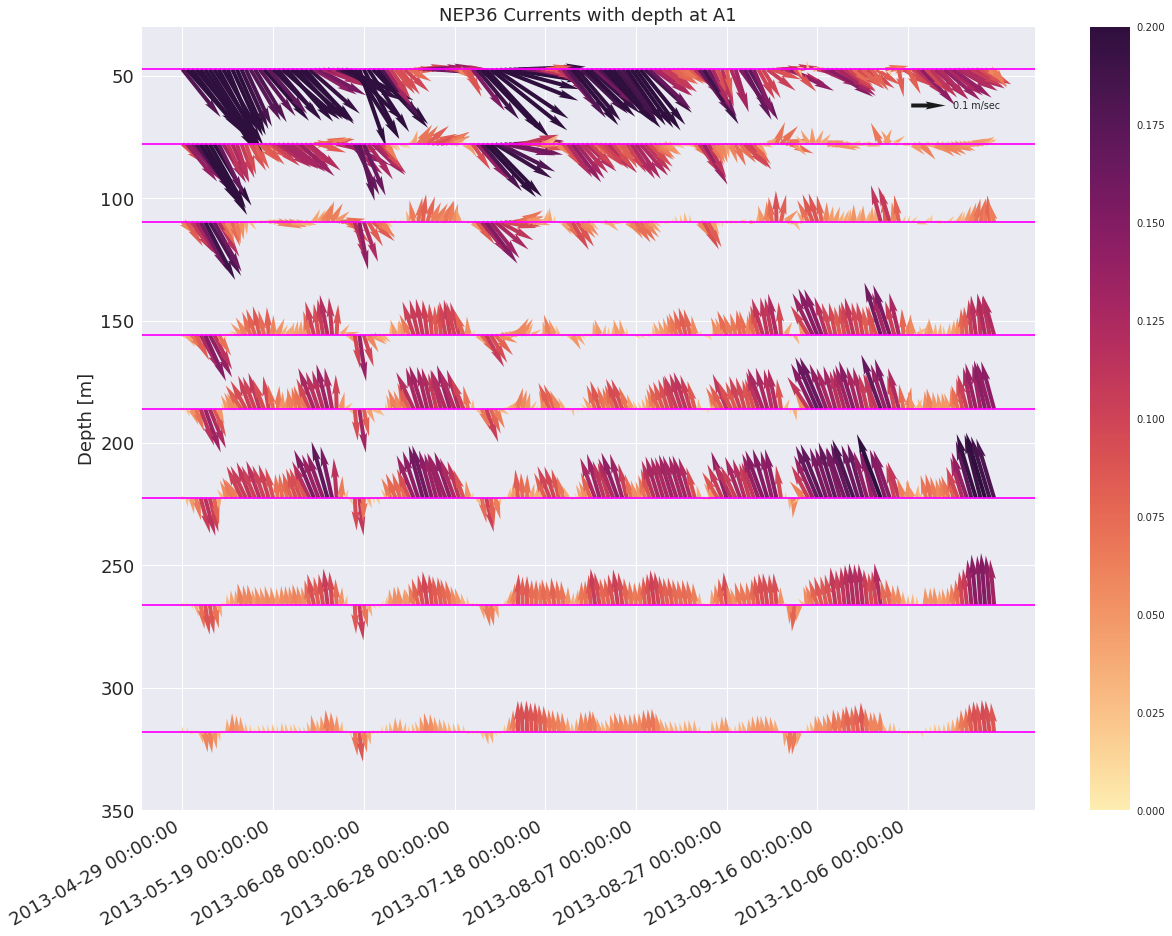

In [121]:
step = 1

# u_84 = vel_east_84[:4320]
# v_84 = vel_north_84[:4320]
# mag_84 = np.sqrt(u_84**2,v_84**2)

time_axis_quiver = np.arange(0,180,step)




# time_axis = datetime_A1[:2420]
# time_tick = time_axis[::step]
# time_axis_quiver = np.arange(0,2420,step)



fig, ax = plt.subplots(1, 1, figsize=(20,16))

# ax.quiver(time_axis_quiver, zlevels[10], v_tzyx[:,10,j,i], u_tzyx[:,10,j,i], mag_vel[:,10,j,i], angles='uv', scale_units='inches')
# ax.axhline(y=zlevels[10], color='magenta', label = '{0} m'.format(zlevels[10]))

ax.quiver(time_axis_quiver, zlevels[17],u_unrotated[:,17,j,i], v_unrotated[:,17,j,i], mag_vel[:,17,j,i], angles='uv',cmap = cm, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[17], color='magenta', label = '{0} m'.format(zlevels[17]))

ax.quiver(time_axis_quiver, zlevels[20], u_unrotated[:,20,j,i], v_unrotated[:,20,j,i], mag_vel[:,20,j,i], angles='uv',cmap = cm, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[20], color='magenta', label = '{0} m'.format(zlevels[20]))

ax.quiver(time_axis_quiver, zlevels[22],  u_unrotated[:,22,j,i], v_unrotated[:,22,j,i], mag_vel[:,22,j,i], angles='uv',cmap = cm, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[22], color='magenta', label = '{0} m'.format(zlevels[22]))

ax.quiver(time_axis_quiver, zlevels[24], u_unrotated[:,24,j,i], v_unrotated[:,24,j,i], mag_vel[:,24,j,i], angles='uv',cmap = cm, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[24], color='magenta', label = '{0} m'.format(zlevels[23]))

ax.quiver(time_axis_quiver, zlevels[25], u_unrotated[:,25,j,i], v_unrotated[:,25,j,i],  mag_vel[:,25,j,i], angles='uv',cmap = cm, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[25], color='magenta', label = '{0} m'.format(zlevels[25]))

Q = ax.quiver(time_axis_quiver, zlevels[26], u_unrotated[:,26,j,i], v_unrotated[:,26,j,i],  mag_vel[:,26,j,i], angles='uv',cmap = cm, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[26], color='magenta', label = '{0} m'.format(zlevels[26]))

Q = ax.quiver(time_axis_quiver, zlevels[27],u_unrotated[:,27,j,i], v_unrotated[:,27,j,i],  mag_vel[:,27,j,i], angles='uv',cmap = cm, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[27], color='magenta', label = '{0} m'.format(zlevels[27]))

Q = ax.quiver(time_axis_quiver, zlevels[28],u_unrotated[:,28,j,i], v_unrotated[:,28,j,i],  mag_vel[:,28,j,i], angles='uv',cmap = cm, norm = norm, scale_units='inches', scale = 0.21, headwidth = 2, headlength = 5)#, scale_units='inches')
ax.axhline(y=zlevels[28], color='magenta', label = '{0} m'.format(zlevels[28]))

# ax.quiver(time_axis_quiver, 84.44, vel_east_84[::step], vel_north_84[::step], mag_84[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=84.44, color='magenta', label = '84 m')

# ax.quiver(time_axis_quiver, 148.44, vel_east_148[::step], vel_north_148[::step], mag_148[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=148.44, color='red', label = '148 m')

# ax.quiver(time_axis_quiver, 196.44, vel_east_196[::step], vel_north_196[::step], mag_196[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=196.44, color='orangered', label = '196 m')

# ax.quiver(time_axis_quiver, 260.44, vel_east_260[::step], vel_north_260[::step], mag_260[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=260.44, color='cyan', label = '196 m')

# ax.quiver(time_axis_quiver, 228.44, vel_east_228[::step], vel_north_228[::step], mag_228[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=228.44, color='purple', label = '228 m')


ax.set_ylabel('Depth [m]', fontsize =18)
plt.xticks(time_axis_quiver[::20], mydates[::20], fontsize =16)
# ax.format_xdata = DateFormatter('%Y-%m-%d')
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# hfmt = DateFormatter('%Y-%m-%d-%H:%M:%S')
# ax.xaxis.set_major_formatter(hfmt)
# ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
fig.autofmt_xdate()
ax.set_ylim(30, 350)
ax.invert_yaxis()
ax.set_title('NEP36 Currents with depth at A1', fontsize =18)
# legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.grid() 
# ax.quiverkey()
ax.quiverkey(Q, 0.9, 0.9, 0.1, r'0.1 m/sec', labelpos='E')
ax.xaxis_date()
ax.tick_params(axis='both',labelsize =18)
# plt.show()
plt.colorbar(sm)

### NEP36 correctly estimates the dip during the MVP survey \
(the slightly reduced northward flow at depth during those days at the end of August and even southward in the real station data)

In [115]:
np.max(mag_148)

0.27959433908276132